In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_19.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_0.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_7.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_4.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_8.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_9.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_6.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_3.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_13.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_1.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_5.png
/kaggle/input/wheat-plant-diseases/data/valid/black_rust_valid/black_rust_12.png
/kaggle/input/wheat-plant-diseases/da

In [2]:
# 导入必要的库
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 检查设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')

使用设备: cuda


In [3]:
# 定义数据集类
class WheatDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # 获取所有类别名称
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}  # 类别名称到索引的映射
        
        self.images = []
        self.labels = []
        
        # 加载所有图片路径和对应标签
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.jpg', '.jpeg', '.png')):
                    self.images.append(os.path.join(class_dir, img_name))
                    self.labels.append(self.class_to_idx[class_name])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # 加载并转换图片
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [4]:
# 定义模型类
class EfficientNetB0Model(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetB0Model, self).__init__()
        # 加载预训练的 EfficientNetB0 模型
        self.model = models.efficientnet_b0(pretrained=True)
        # 替换最后的分类层
        num_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.2),  # 添加 Dropout 防止过拟合
            nn.Linear(num_features, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

# 定义数据转换
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整图片大小
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

# 加载测试数据集
test_dataset = WheatDiseaseDataset(root_dir="/kaggle/input/wheat-plant-diseases/data/test", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f'测试集样本数: {len(test_dataset)}')
print(f'类别数: {len(test_dataset.classes)}')
print('类别名称:', test_dataset.classes)

# 初始化模型
model = EfficientNetB0Model(num_classes=len(test_dataset.classes))
model = model.to(device)

# 加载预训练权重
model.load_state_dict(torch.load('/kaggle/input/best_model/pytorch/default/1/best_model.pth'))
model.eval()

测试集样本数: 750
类别数: 15
类别名称: ['aphid_test', 'black_rust_test', 'blast_test', 'brown_rust_test', 'common_root_rot_test', 'fusarium_head_blight_test', 'healthy_test', 'leaf_blight_test', 'mildew_test', 'mite_test', 'septoria_test', 'smut_test', 'stem_fly_test', 'tan_spot_test', 'yellow_rust_test']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 174MB/s]


EfficientNetB0Model(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (s

In [5]:
# 获取预测结果
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():  # 不计算梯度
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # 获取预测概率
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

# 转换为numpy数组
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# 计算准确率
accuracy = (all_preds == all_labels).mean()
print(f'测试集准确率: {accuracy:.4f}')

# 打印详细的分类报告
print("\n分类报告:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

测试集准确率: 0.7627

分类报告:
                           precision    recall  f1-score   support

               aphid_test       0.91      0.80      0.85        50
          black_rust_test       0.83      0.58      0.68        50
               blast_test       0.93      0.84      0.88        50
          brown_rust_test       0.58      0.56      0.57        50
     common_root_rot_test       0.84      0.96      0.90        50
fusarium_head_blight_test       0.95      0.78      0.86        50
             healthy_test       0.57      0.08      0.14        50
         leaf_blight_test       0.64      0.82      0.72        50
              mildew_test       0.94      0.92      0.93        50
                mite_test       0.68      0.56      0.62        50
            septoria_test       0.98      0.92      0.95        50
                smut_test       0.82      1.00      0.90        50
            stem_fly_test       1.00      1.00      1.00        50
            tan_spot_test       0.60   

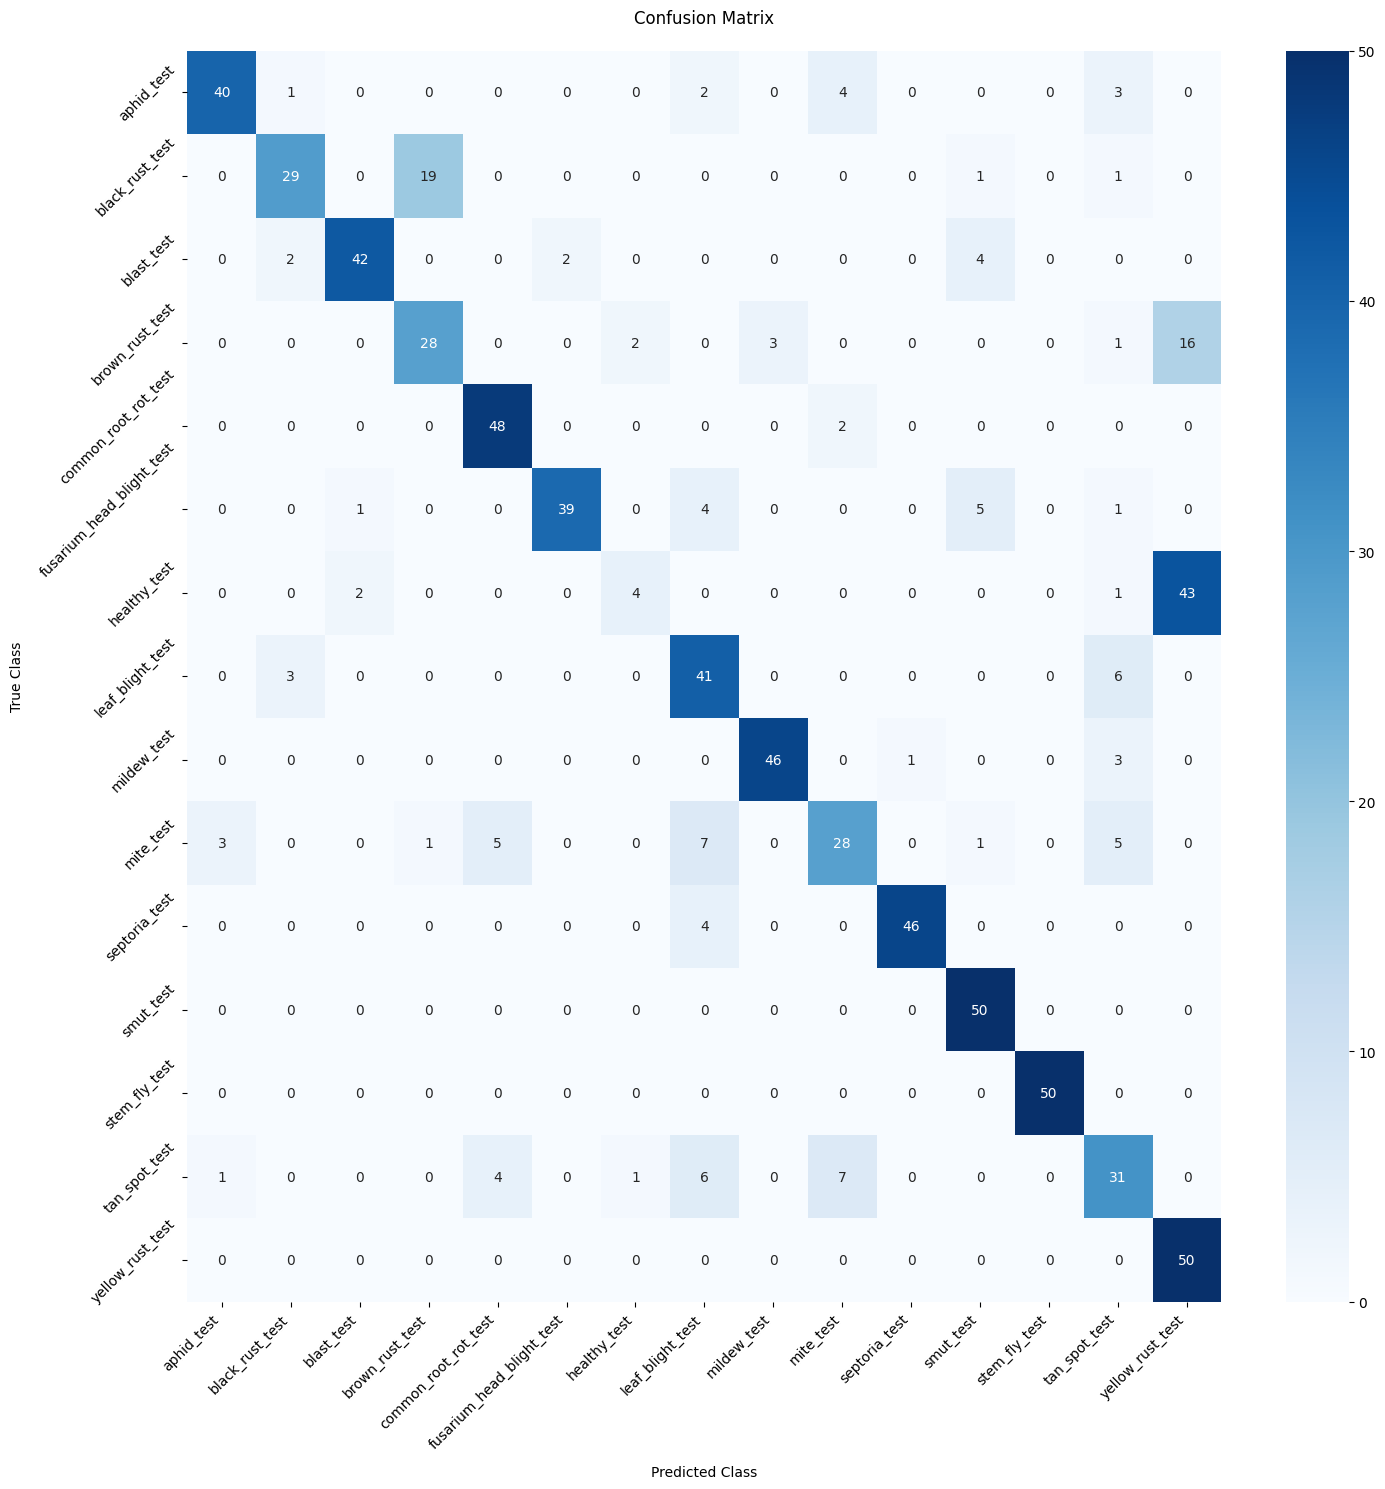

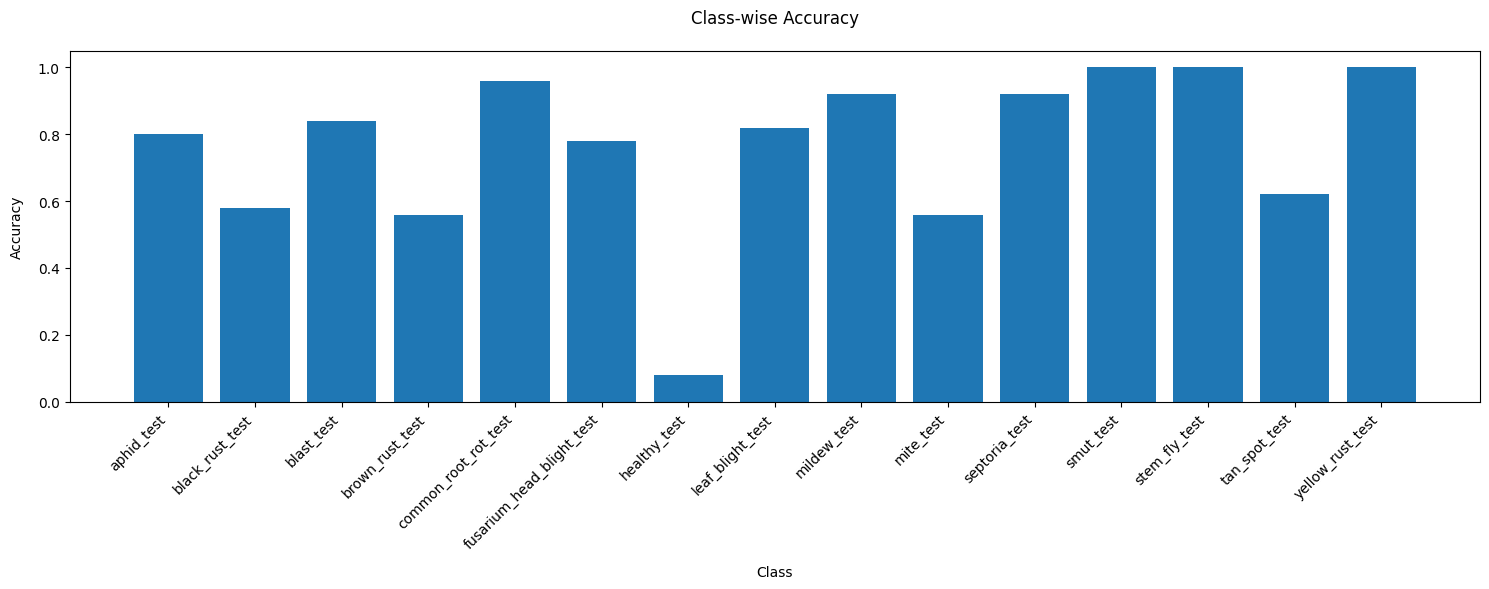

In [6]:
# 绘制混淆矩阵的函数
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix', pad=20)  # 使用英文标题
    plt.xlabel('Predicted Class', labelpad=10)  # 使用英文标签
    plt.ylabel('True Class', labelpad=10)  # 使用英文标签
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 绘制混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, test_dataset.classes)

# 绘制各类别准确率
class_accuracies = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(15, 6))
plt.bar(range(len(test_dataset.classes)), class_accuracies)
plt.title('Class-wise Accuracy', pad=20)  # 使用英文标题
plt.xlabel('Class', labelpad=10)  # 使用英文标签
plt.ylabel('Accuracy', labelpad=10)  # 使用英文标签
plt.xticks(range(len(test_dataset.classes)), test_dataset.classes, rotation=45, ha='right')
plt.tight_layout()
plt.show()

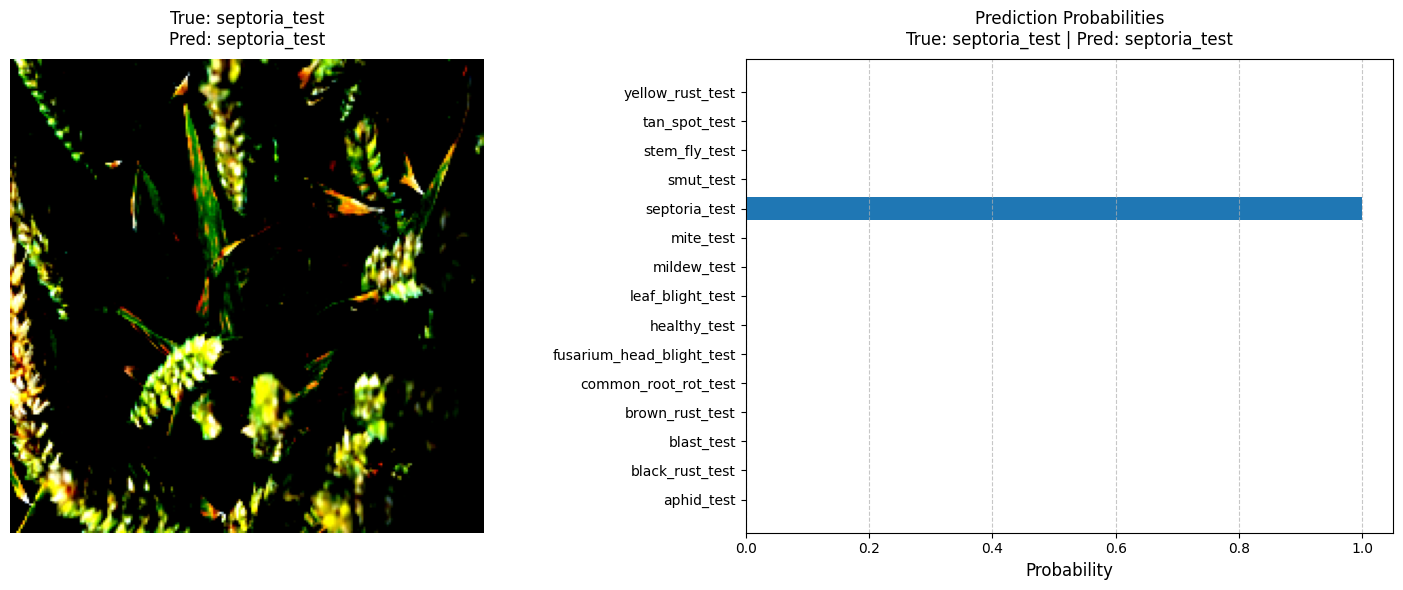

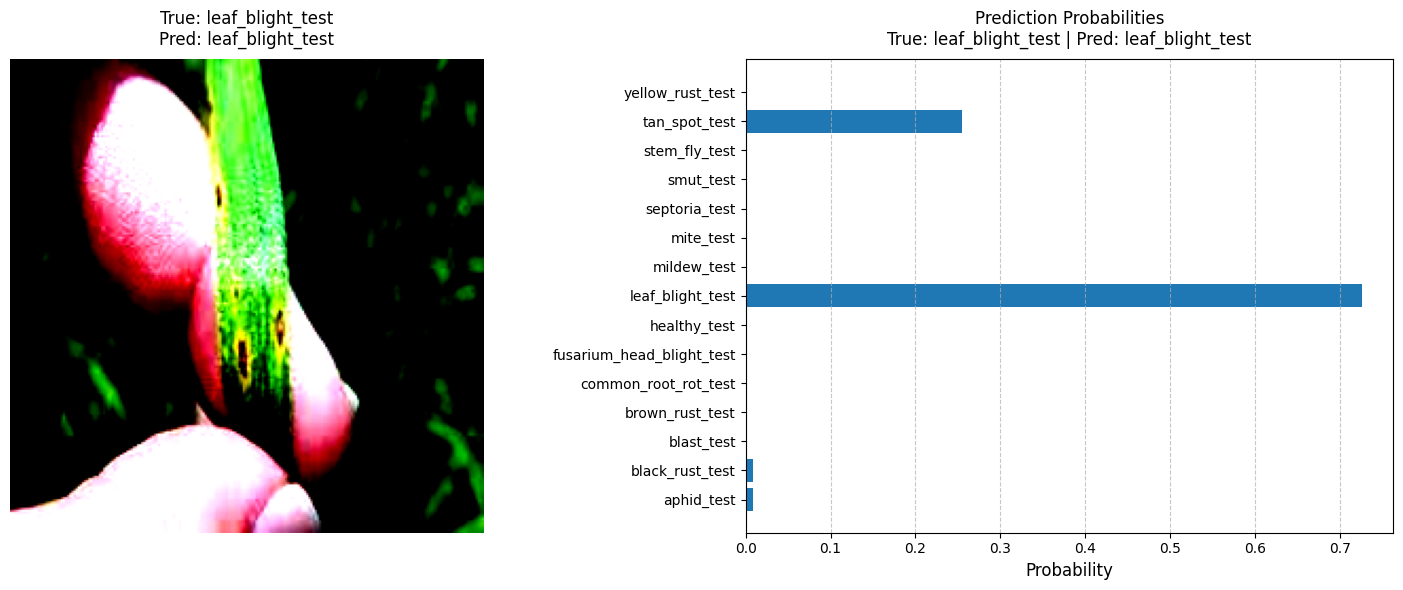

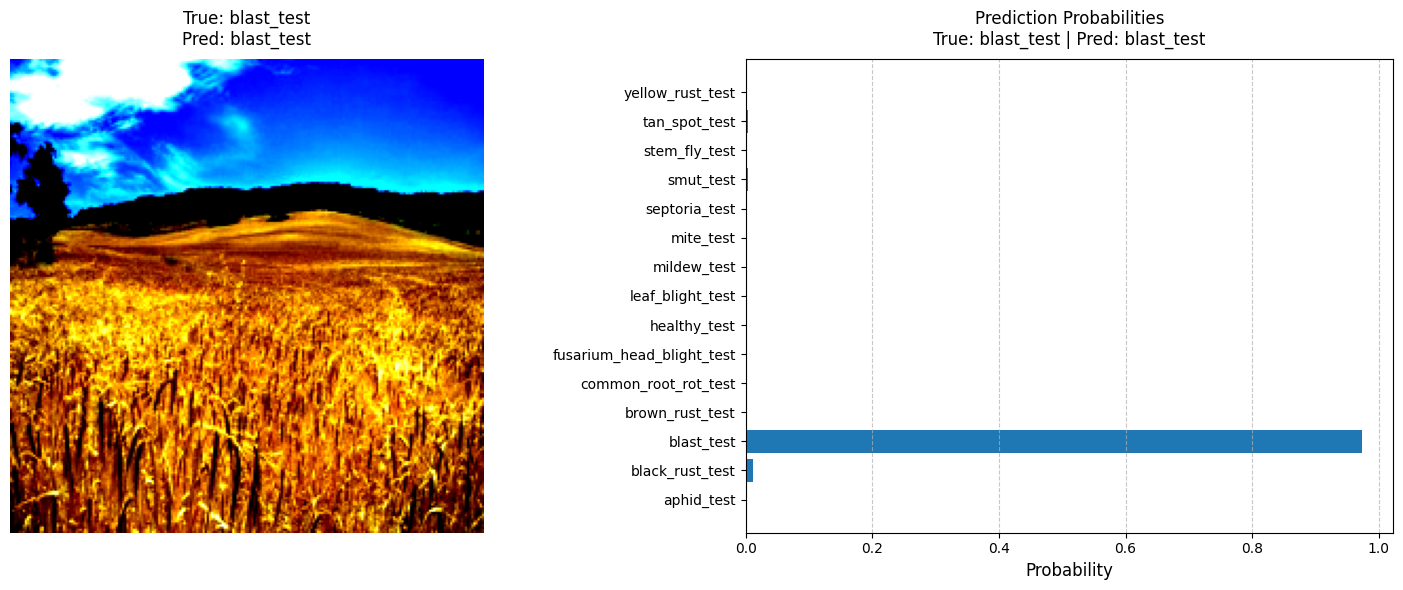

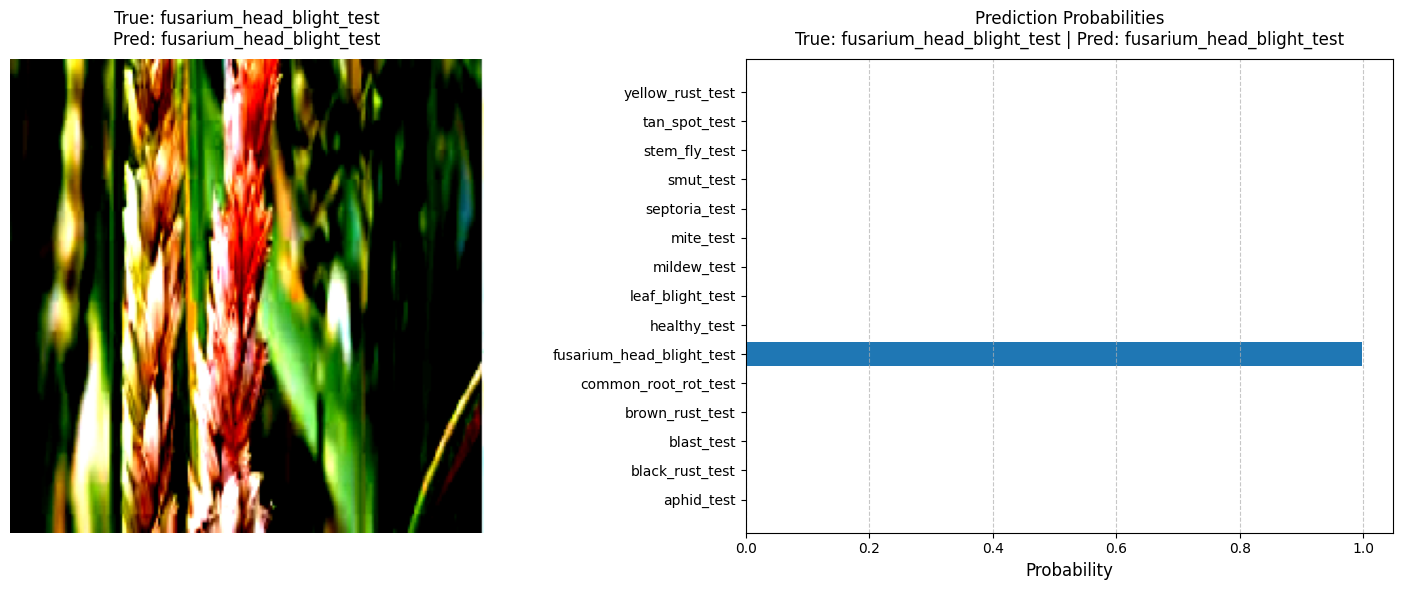

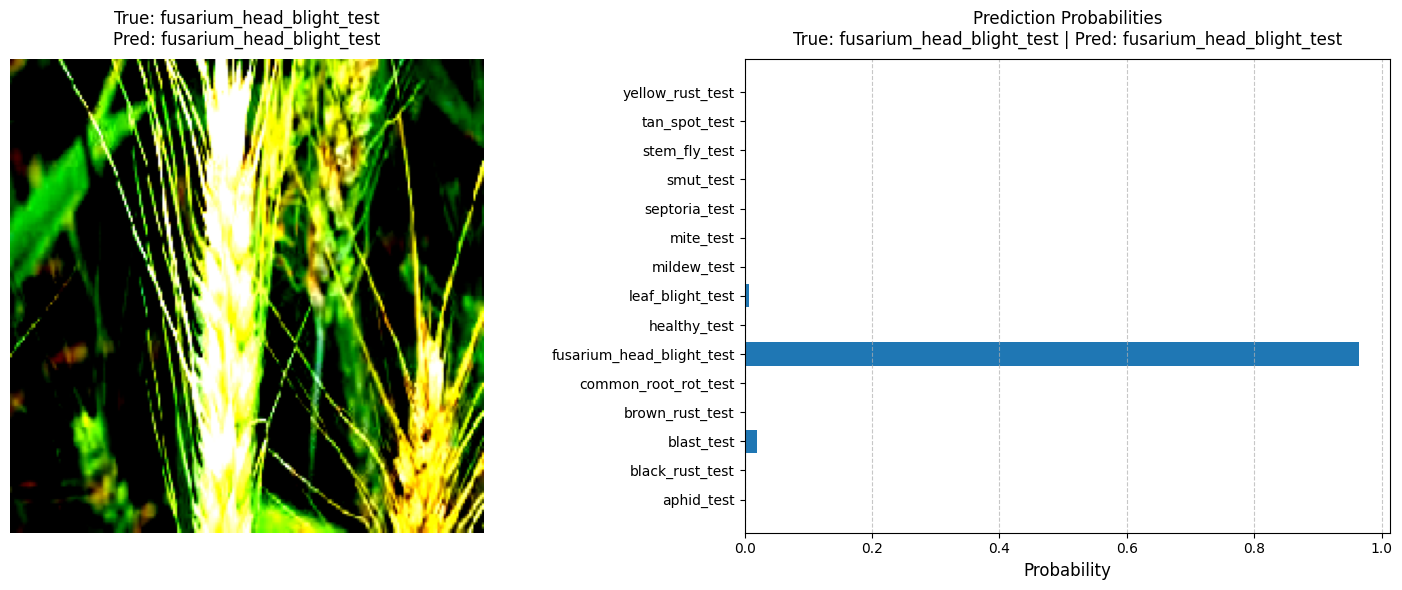

In [7]:
# 随机选择5张图片进行预测
num_samples = 5
indices = np.random.choice(len(test_dataset), num_samples, replace=False)
sample_images = [test_dataset[i][0] for i in indices]
sample_labels = [test_dataset[i][1] for i in indices]

# 获取预测结果
with torch.no_grad():
    sample_outputs = model(torch.stack(sample_images).to(device))
    sample_probs = torch.softmax(sample_outputs, dim=1)
    sample_preds = torch.argmax(sample_probs, dim=1)

# 转换为numpy数组
all_probs = sample_probs.cpu().numpy()
all_preds = sample_preds.cpu().numpy()
all_labels = np.array(sample_labels)

# 为每张图片创建独立的组合图
for i in range(num_samples):
    plt.figure(figsize=(15, 6))  # 每张组合图的宽度和高度
    
    # 左侧显示图片
    plt.subplot(1, 2, 1)
    plt.imshow(sample_images[i].permute(1, 2, 0).cpu().numpy())
    plt.title(f'True: {test_dataset.classes[all_labels[i]]}\nPred: {test_dataset.classes[all_preds[i]]}', 
              fontsize=12, pad=10)
    plt.axis('off')
    
    # 右侧显示预测概率
    plt.subplot(1, 2, 2)
    plt.barh(range(len(all_probs[i])), all_probs[i])
    plt.yticks(range(len(all_probs[i])), test_dataset.classes, fontsize=10)
    plt.xlabel('Probability', fontsize=12)
    plt.title(f'Prediction Probabilities\nTrue: {test_dataset.classes[all_labels[i]]} | Pred: {test_dataset.classes[all_preds[i]]}', 
              fontsize=12, pad=10)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

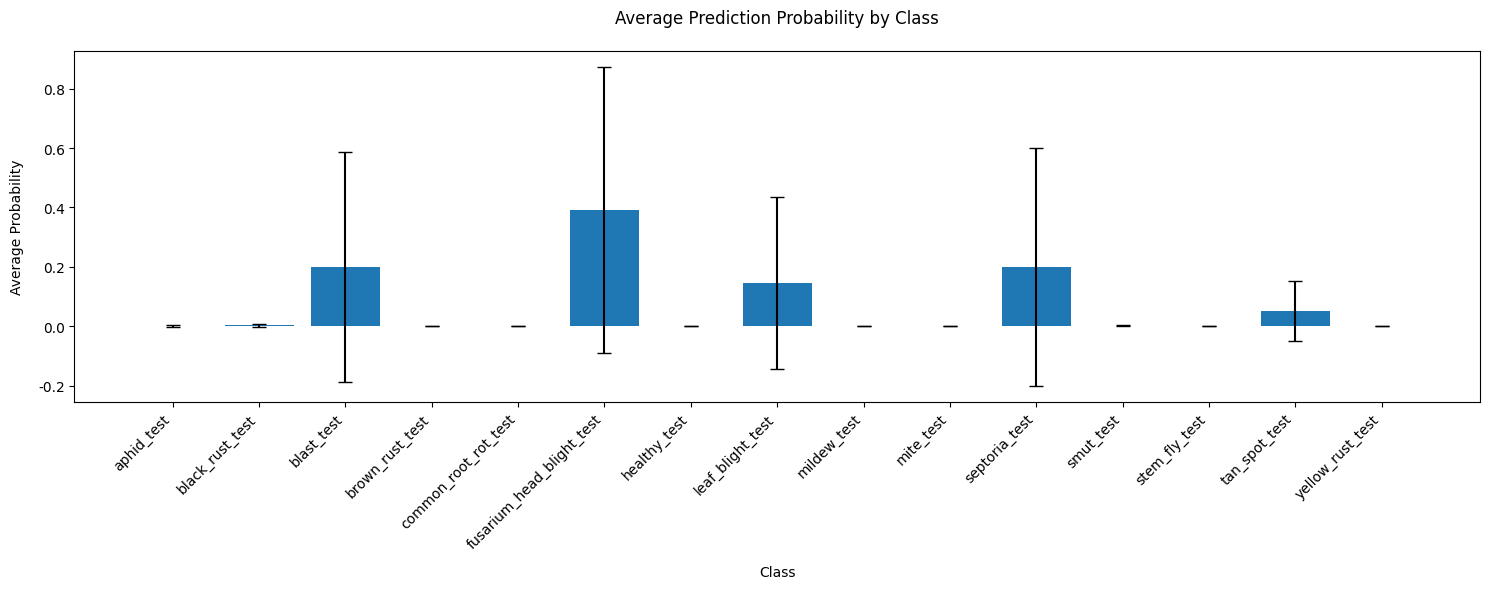

In [8]:
# 绘制预测概率分布
def plot_probability_distribution(all_probs, all_labels, classes):
    plt.figure(figsize=(15, 6))
    
    # 计算每个类别的平均预测概率
    mean_probs = np.mean(all_probs, axis=0)
    std_probs = np.std(all_probs, axis=0)
    
    # 绘制条形图
    plt.bar(range(len(classes)), mean_probs, yerr=std_probs, capsize=5)
    plt.title('Average Prediction Probability by Class', pad=20)  # 使用英文
    plt.xlabel('Class', labelpad=10)  # 使用英文
    plt.ylabel('Average Probability', labelpad=10)  # 使用英文
    plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 绘制预测概率分布
plot_probability_distribution(all_probs, all_labels, test_dataset.classes)